In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np


In [2]:
#using pretrained model RESNET, source: https://pytorch.org/hub/pytorch_vision_resnet/
model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)

train_on_gpu = torch.cuda.is_available()

classes = ['closed', 'open']
print('training on GPU' if train_on_gpu else 'training on CPU')

Using cache found in /home/ahmad/.cache/torch/hub/pytorch_vision_v0.4.2
training on CPU


In [3]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plot = plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [4]:
###########################
# Criterion And Optimizer #
###########################

import torch.optim as optim
# Loss function chosen based on log soft max layer in the model
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [5]:
####################
# Making The Model #
####################

# edit fc "the last layer in the model" to suit our needs
#the layer has 512 input features
model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 12),
                                 nn.LogSoftmax(dim=1))
model.load_state_dict(torch.load('trained_model_RESNET18.pt', map_location=torch.device('cuda' if train_on_gpu else 'cpu')))
if train_on_gpu:
    model.cuda()

In [6]:
def show(img):
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [27]:
##############################################
# uncomment this cell to test a single image #
##############################################

'''from face import Face
import matplotlib.pyplot as plt
from PIL import Image

face = Face()
eye1, eye2 = face.detect_eyes_dlib()

#print(eye1, eye2)

plot = plt.imshow(eye1)
plot2 = plt.imshow(eye2)'''

'from face import Face\nimport matplotlib.pyplot as plt\nfrom PIL import Image\n\nface = Face()\neye1, eye2 = face.detect_eyes_dlib()\n\n#print(eye1, eye2)\n\nplot = plt.imshow(eye1)\nplot2 = plt.imshow(eye2)'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
12
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
13
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
12
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
11
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)

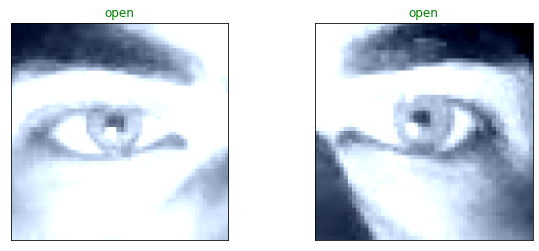

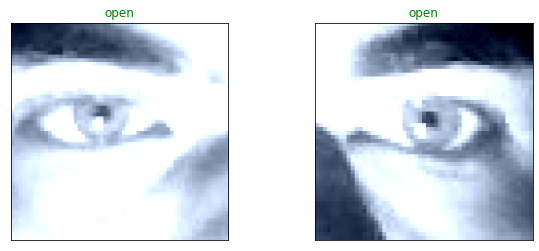

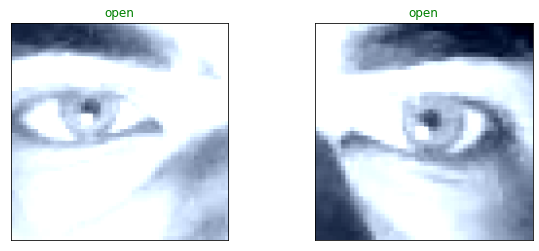

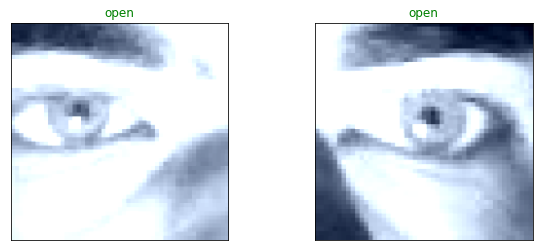

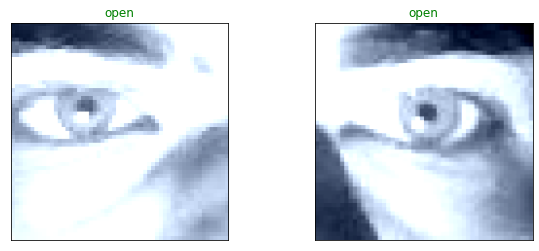

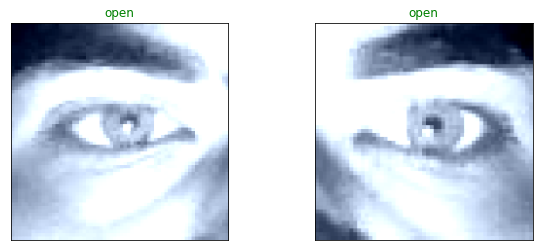

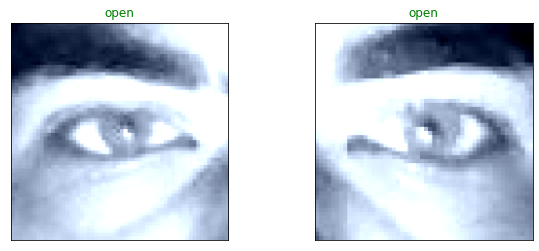

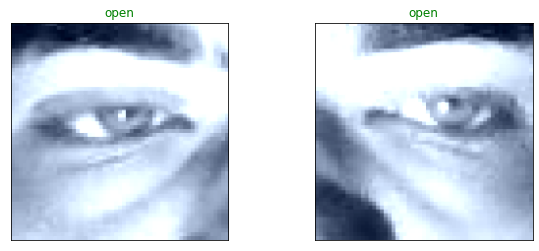

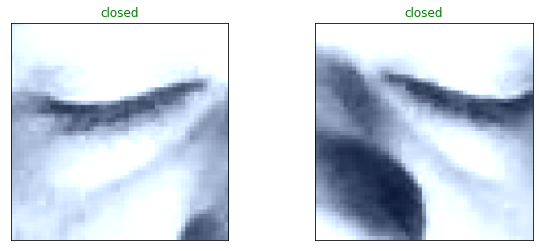

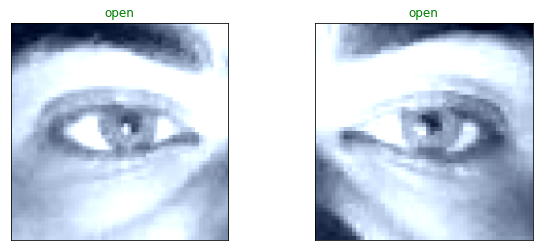

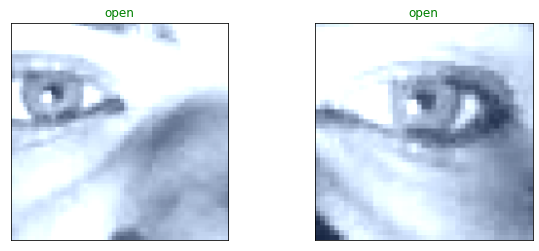

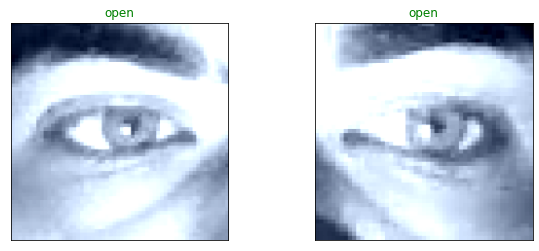

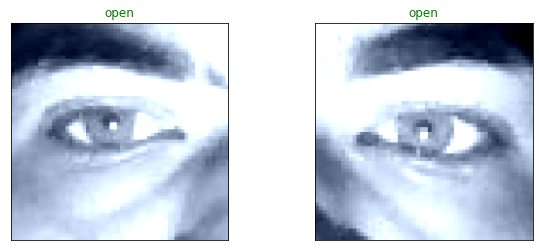

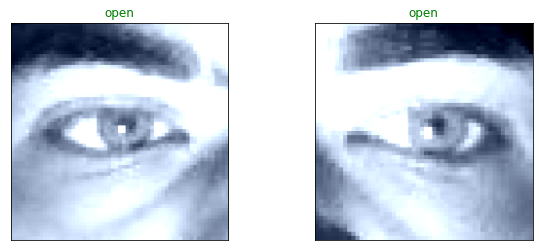

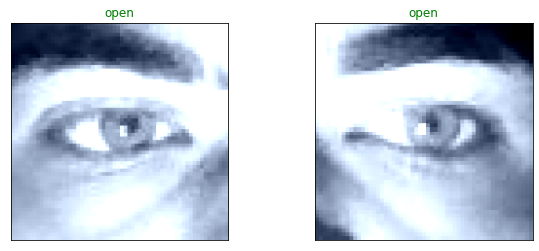

In [26]:
from face import Face
import time
import cv2 

num_iterations = 15
delay = 0.5

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

face = Face()

i = 0
while (i < num_iterations):
    i += 1
    try:
        eye1, eye2 = face.detect_eyes_dlib() # use face.detect_eyes() for haarcascade algorithm

        eye1 = cv2.resize(eye1, (224,224), interpolation = cv2.INTER_AREA)
        eye2 = cv2.resize(eye2, (224,224), interpolation = cv2.INTER_AREA)

        eye1, eye2 = transform(eye1), transform(eye2)
        #print(eye1.shape)
        eyes = [eye1, eye2]
        eyes = torch.stack(eyes)
        #print(eyes.shape)

        model.eval()
        with torch.no_grad():
            #dataiter = iter(testloader)
            #images, labels = dataiter.next()
            eyes = eyes.cpu()
            eyes.numpy()
            
            if train_on_gpu:
                eyes = eyes.cuda()
            output = model(eyes)
            # convert output probabilities to predicted class
            _, predection = torch.max(output, 1)
            # conver the predection tensor into a numpy array
            predection = predection.cpu().numpy() if train_on_gpu else predection.numpy()
            #print(predection)
            # plot the images in the batch, along with predicted and true labels
            fig = plt.figure(figsize=(10, 4))
            for idx in np.arange(2):
                ax = fig.add_subplot(1, 2, idx+1, xticks=[], yticks=[])
                imshow(eyes.cpu()[idx])
                #print(predection[0])
                ax.set_title("{}".format(classes[predection[idx]]),
                            color=("green"))
            time.sleep(delay)
    except:
        print('error')
cv2.destroyAllWindows()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[1 1]
1
1


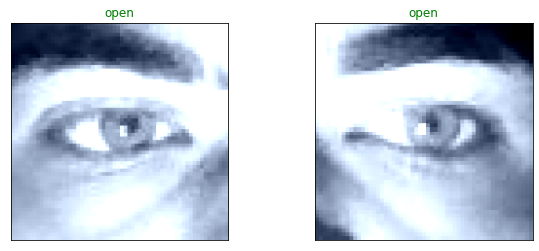

In [28]:
model.eval()
with torch.no_grad():
    #dataiter = iter(testloader)
    #images, labels = dataiter.next()
    eyes = eyes.cpu()
    eyes.numpy()
    
    if train_on_gpu:
        eyes = eyes.cuda()
    output = model(eyes)
    # convert output probabilities to predicted class
    _, predection = torch.max(output, 1)
    # conver the predection tensor into a numpy array
    predection = predection.cpu().numpy() if train_on_gpu else predection.numpy()
    print(predection)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(10, 4))
    for idx in np.arange(2):
        ax = fig.add_subplot(1, 2, idx+1, xticks=[], yticks=[])
        imshow(eyes.cpu()[idx])
        print(predection[0])
        ax.set_title("{}".format(classes[predection[idx]]),
                    color=("green"))